# Data preparation

In [ ]:
# pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import xgboost as xgb
import sklearn

features = pd.read_csv('hfactory_magic_folders/hi__paris_hackathon/building_energy_efficiency/datasets/train/train_features_sent.csv',
                       #dtype={'has_balcony':bool},
                       parse_dates=['consumption_measurement_date'])
labels = pd.read_csv('hfactory_magic_folders/hi__paris_hackathon/building_energy_efficiency/datasets/train/train_labels_sent.csv')

train = features.merge(labels)

train.dropna(subset=['has_balcony'], inplace=True)
train['has_balcony'] = train['has_balcony'].astype('bool')
    
test = pd.read_csv('hfactory_magic_folders/hi__paris_hackathon/building_energy_efficiency/datasets/test/test_features_sent.csv',
                   parse_dates=['consumption_measurement_date'])

train.head()

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,level_0,additional_heat_generators,additional_water_heaters,altitude,area_code,balcony_depth,bearing_wall_material,building_category,building_class,building_height_ft,...,water_heaters,water_heating_energy_source,water_heating_type,window_filling_type,window_frame_material,window_glazing_type,window_heat_retention_factor,window_orientation,window_thermal_conductivity,energy_consumption_per_annum
0,111323,[wood stove or insert],NaN,328.08400,881,NaN,CONCRETE,[],[],13.779528,...,[indeterminate oil boiler],oil,individual,argon or krypton,pvc,double glazing,1.116894,"[est,west]",15.347292,290.166345
1,265182,[],NaN,360.89240,260,NaN,NaN,[condo],[2 to 11],43.635172,...,[indeterminate gas boiler],gas,individual,argon or krypton,wood,double glazing,1.133072,"[est,west,sud]",17.512631,169.818197
2,927507,[],NaN,324.80316,573,NaN,WOOD - OTHER,[],[],19.685040,...,[standard gas boiler],gas,individual,dry air,pvc,double glazing,1.084204,"[est,west]",16.779108,144.499711
3,874620,[],NaN,288.71392,204,NaN,BRICKS,[],[],13.779528,...,[electric storage tank],electricity,individual,NaN,metal with thermal break,triple glazing,0.983338,"[est,north,sud]",12.630033,158.742715
4,563274,[],NaN,849.73756,374,NaN,GRITSTONE,[individual house],[individual],19.028872,...,[thermodynamic electric hot water (pac or tank)],thermodynamic electric hot water (heat pump or...,individual,dry air,pvc,double glazing,1.084204,"[north,sud]",13.290529,82.223648


In [2]:
def preprocessing(df):
    
    df['has_balcony'] = df['has_balcony'].astype('bool')
    
    # dates features machine learning : https://towardsdatascience.com/make-your-machine-learning-model-work-better-with-datetime-features-eb21de397fe8
    df['year'] = df['consumption_measurement_date'].dt.year
    df['month'] = df['consumption_measurement_date'].dt.month
    df['day'] = df['consumption_measurement_date'].dt.day
    
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12.0)
    
    df['day_sin'] = np.sin(2 * np.pi * df['day']/365.0)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/365.0)
    
    df.drop(['consumption_measurement_date', 'month', 'day'], 1, inplace = True)
    
    
    # enlever les espaces après ? pas la peine à priori
    
    multi_label = ['building_category',
                   'building_class',
                   'heat_generators',
                   'main_heating_type',
                   'main_water_heating_type',
                   'water_heaters',
                   'window_orientation'] # on garde undetermined
    
    for col in multi_label: # + ['bearing_wall_material']
        df[col] = df[col].str.replace(
            '(, *(nan|NaN|null|NULL) *| *(nan|NaN|null|NULL) *,)','').str.replace(
            '\[(nan|NaN|null|NULL)\]','') # dans une autre boucle pour que le cas échéant le dernier soit également supprimé
        #, ou [ / ] : si en début ou fin
        # pas les virgules en ? car si null entouré de deux virgules, on ne veut en retirer qu'une
        # nan in building_category et bearing_wall_material
        # NaN in bearing_wall_material
        # null in building class
        # NULL in building_category

    for col in ['additional_heat_generators',
                'additional_water_heaters',
                'main_heating_type',
                'main_water_heating_type',
                'water_heaters']: 
        df[col] = df[col].str.replace('(indeterminate|indetermine) *', '') # indetermine in additional_heat_generators

    # or rstrip(',') to remove the last comma if there was a null in the list

    for col in multi_label + ['additional_heat_generators']: # additional_heat_generators: pas de multi-labels
        df[col] = df[col].str.replace('(\[|\])','').str.split(',').apply(np.unique).apply(sorted)

    df['renewable_energy_sources'] = df['renewable_energy_sources'].str.replace(' + heating)',
                                                                                '+heating)',
                                                                                regex = False)

    # + avec un espace
    for col in ['heating_energy_source',
                'renewable_energy_sources',
                'water_heating_energy_source']:
        df[col] = df[col].fillna('').str.split(' \+ ').apply(np.unique).apply(sorted)
        # fillna pour renewable_energy_sources

    # + sans espace
    for col in ['upper_floor_insulation_type', 'wall_insulation_type']:
        df[col] = df[col].fillna('').str.split('+').apply(np.unique).apply(sorted)

    # -
    df['bearing_wall_material'] = df['bearing_wall_material'].str.replace('BRICKS','BRICK')
    for col in ['bearing_wall_material', 'roof_material']:
        df[col] = df[col].fillna('').str.split(' - ').apply(np.unique).apply(sorted)
        # fillna pour bearing_wall_material

    df['balcony_depth'] = pd.to_numeric(df['balcony_depth'].str[0].replace('<','0'))

    df.loc[df['outer_wall_thickness'].str[-1:] == '-','outer_wall_thickness_minus'] = 1
    df.loc[df['outer_wall_thickness'].str.isnumeric() == True,'outer_wall_thickness_minus'] = 0
    # OK : train.loc[train['outer_wall_thickness'].isna(),['outer_wall_thickness', 'outer_wall_thickness_minus']]

    # Après avoir récupéré l'info sur le -, on supprime pour convertir en int
    df['outer_wall_thickness'] = pd.to_numeric(df['outer_wall_thickness'].str.replace(' et -', ''))


    return df



def one_hot(df):
    
    df_hot = df[['level_0']]


    for col in df.select_dtypes(exclude=['int64', 'float64', 'bool']).columns:
        # is_crossing_building : not bool

        print(col)
        df[col].fillna('', inplace=True)

        mlb = MultiLabelBinarizer()
        if type(df.loc[1,col])==str:
            df[col] = df[col].str.split(',,')
        mlb.fit(df[col])
  

        new_col_names = [col + "_%s" % c for c in mlb.classes_]

        # Create new DataFrame with transformed/one-hot encoded
        hot = pd.DataFrame(mlb.fit_transform(df[col]),
                           columns=new_col_names,
                           index=df[col].index)

        # Concat with original label column
        df_hot = pd.concat([df_hot, hot], axis=1)

        if col+"_" in new_col_names:
            df_hot.drop(col+"_", axis=1, inplace=True)
            
    df_hot = pd.concat([df.select_dtypes(include=['int64', 'float64', 'bool']), df_hot.drop('level_0', 1)], axis=1)
        
    return df_hot

In [61]:
train = preprocessing(train)

/tmp/ipykernel_5145/3355744473.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace(
/tmp/ipykernel_5145/3355744473.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('(indeterminate|indetermine) *', '') # indetermine in additional_heat_generators
/tmp/ipykernel_5145/3355744473.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('(\[|\])','').str.split(',').apply(np.unique).apply(sorted)


In [62]:
train_hot = one_hot(train)

additional_heat_generators
additional_water_heaters
bearing_wall_material
building_category
building_class
building_period
building_type
building_use_type_description
clay_risk_level
heat_generators
heating_energy_source
heating_type
is_crossing_building
lower_floor_adjacency_type
lower_floor_insulation_type
lower_floor_material
main_heat_generators
main_heating_type
main_water_heaters
main_water_heating_type
outer_wall_materials
radon_risk_level
renewable_energy_sources
roof_material
thermal_inertia
upper_floor_adjacency_type
upper_floor_insulation_type
upper_floor_material
ventilation_type
wall_insulation_type
water_heaters
water_heating_energy_source
water_heating_type
window_filling_type
window_frame_material
window_glazing_type
window_orientation


In [63]:
test = preprocessing(test)

/tmp/ipykernel_5145/3355744473.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace(
/tmp/ipykernel_5145/3355744473.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('(indeterminate|indetermine) *', '') # indetermine in additional_heat_generators
/tmp/ipykernel_5145/3355744473.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('(\[|\])','').str.split(',').apply(np.unique).apply(sorted)


In [64]:
test_hot = one_hot(test)

additional_heat_generators
additional_water_heaters
bearing_wall_material
building_category
building_class
building_period
building_type
building_use_type_description
clay_risk_level
heat_generators
heating_energy_source
heating_type
is_crossing_building
lower_floor_adjacency_type
lower_floor_insulation_type
lower_floor_material
main_heat_generators
main_heating_type
main_water_heaters
main_water_heating_type
outer_wall_materials
radon_risk_level
renewable_energy_sources
roof_material
thermal_inertia
upper_floor_adjacency_type
upper_floor_insulation_type
upper_floor_material
ventilation_type
wall_insulation_type
water_heaters
water_heating_energy_source
water_heating_type
window_filling_type
window_frame_material
window_glazing_type
window_orientation


In [ ]:
#print(*train_hot.columns, sep = '\n')
len(test_hot.columns), len(train_hot.columns)

In [3]:
#train_hot.to_csv('train_hot.csv')
train_hot = pd.read_csv('train_hot.csv', index_col=0)
train_hot.head()

,level_0,altitude,area_code,balcony_depth,building_height_ft,building_total_area_sqft,building_use_type_code,building_year,has_air_conditioning,has_balcony,...,window_glazing_type_overglazing,window_glazing_type_single glazing,window_glazing_type_triple glazing,window_orientation_east or west,window_orientation_est,window_orientation_horizontal,window_orientation_north,window_orientation_sud,window_orientation_undetermined,window_orientation_west
0,111323,328.08400,881,NaN,13.779528,1291.6680,1,1979.0,False,False,...,0,0,0,0,1,0,0,0,0,1
1,265182,360.89240,260,NaN,43.635172,7136.4657,2,NaN,False,False,...,0,0,0,0,1,0,0,1,0,1
2,927507,324.80316,573,NaN,19.685040,4197.9210,2,1810.0,False,False,...,0,0,0,0,1,0,0,0,0,1
3,874620,288.71392,204,NaN,13.779528,1646.8767,1,1972.0,False,True,...,0,0,1,0,1,0,1,1,0,0
4,563274,849.73756,374,NaN,19.028872,1033.3344,1,2012.0,False,False,...,0,0,0,0,0,0,1,1,0,0


In [4]:
#test_hot.to_csv('test_hot.csv', index_col=0)
test_hot = pd.read_csv('test_hot.csv', index_col=0)
test_hot.head()

,level_0,altitude,area_code,balcony_depth,building_height_ft,building_total_area_sqft,building_use_type_code,building_year,has_air_conditioning,has_balcony,...,window_glazing_type_overglazing,window_glazing_type_single glazing,window_glazing_type_triple glazing,window_orientation_east or west,window_orientation_est,window_orientation_horizontal,window_orientation_north,window_orientation_sud,window_orientation_undetermined,window_orientation_west
0,1371914,249.34384,615,NaN,19.685040,581.2506,1,1965.0,False,False,...,0,0,0,0,0,0,1,1,0,0
1,618756,104.98688,304,NaN,28.215224,721.1813,1,1850.0,False,False,...,0,0,0,0,0,0,0,0,0,1
2,871032,72.17848,204,NaN,25.918636,699.6535,1,1966.0,False,False,...,0,0,0,0,0,0,1,1,0,0
3,1430640,800.52496,858,NaN,15.748032,1248.6124,1,2001.0,False,False,...,0,0,0,0,1,0,0,0,0,1
4,86306,1010.49872,671,NaN,0.000000,1345.4875,1,2008.0,False,False,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_hot.columns[~test_hot.columns.isin(train_hot.columns)] #colonnes de test pas dans train

Index(['building_period_bad inf', 'water_heaters_chaudiere charbon standard'], dtype='object')

In [6]:
test_hot.columns[~test_hot.columns.isin(train_hot.columns)]

Index(['building_period_bad inf', 'water_heaters_chaudiere charbon standard'], dtype='object')

In [7]:
test_hot.drop(test_hot.columns[~test_hot.columns.isin(train_hot.columns)],
              1,
              inplace = True)

In [8]:
train_hot.drop(train_hot.columns[
    ~train_hot.columns.isin(list(test_hot.columns)+['energy_consumption_per_annum'])],
               1,
               inplace = True)

In [15]:
len(train_hot.columns), len(test_hot.columns)

(489, 488)

# Data exploration

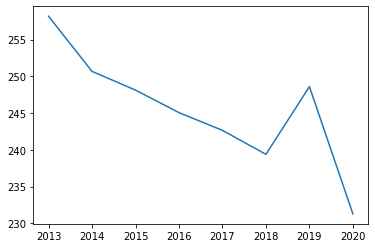

In [16]:
plt.plot(train.groupby('year').mean()['energy_consumption_per_annum'])

In [19]:
train.head()

,level_0,additional_heat_generators,additional_water_heaters,altitude,area_code,balcony_depth,bearing_wall_material,building_category,building_class,building_height_ft,...,window_heat_retention_factor,window_orientation,window_thermal_conductivity,energy_consumption_per_annum,year,month_sin,month_cos,day_sin,day_cos,outer_wall_thickness_minus
0,111323,[wood stove or insert],NaN,328.08400,881,NaN,[CONCRETE],[],[],13.779528,...,1.116894,"[est, west]",15.347292,290.166345,2018,1.000000e+00,6.123234e-17,0.238673,0.971100,1.0
1,265182,[],NaN,360.89240,260,NaN,[],[condo],[2 to 11],43.635172,...,1.133072,"[est, sud, west]",17.512631,169.818197,2020,8.660254e-01,5.000000e-01,0.353676,0.935368,1.0
2,927507,[],NaN,324.80316,573,NaN,"[OTHER, WOOD]",[],[],19.685040,...,1.084204,"[est, west]",16.779108,144.499711,2016,1.224647e-16,-1.000000e+00,0.238673,0.971100,1.0
3,874620,[],NaN,288.71392,204,NaN,[BRICK],[],[],13.779528,...,0.983338,"[est, north, sud]",12.630033,158.742715,2016,-8.660254e-01,5.000000e-01,0.401488,0.915864,0.0
4,563274,[],NaN,849.73756,374,NaN,[GRITSTONE],[individual house],[individual],19.028872,...,1.084204,"[north, sud]",13.290529,82.223648,2019,5.000000e-01,8.660254e-01,0.353676,0.935368,1.0


In [17]:
len(train)

1010328

In [98]:
features.columns[19]

'has_balcony'

In [156]:
100*len(features.loc[~features['has_balcony'].isin([True, False]),'has_balcony'])/len(train)

0.03522367030644593

In [161]:
features.loc[42209,'building_class']

'[null,null,null,null,null,null,null,null,null,null]'

In [165]:
train.loc[42209,'building_class']

['']

In [166]:
#features.loc[features['main_water_heating_type'].str.contains('indeterminate indeterminate'),
#        'main_water_heating_type']

#features.loc[features['renewable_energy_sources'].str.contains('\+ heating\)') == True,
#        'renewable_energy_sources']

In [104]:
features.renewable_energy_sources.value_counts()
features.wall_insulation_type.value_counts()
features.water_heating_energy_source.value_counts()

electricity                                                            543657
gas                                                                    333941
oil                                                                     62729
thermodynamic electric hot water (heat pump or tank)                    40206
wood + gas                                                              10537
thermodynamic electric hot water (pac or tank) + gas                     9330
heat network                                                             2671
wood                                                                     1872
thermodynamic electric hot water (heat pump or tank) + oil               1708
lpg/butane/propane                                                       1468
wood + oil                                                               1149
gas + lpg/butane/propane                                                  681
thermodynamic electric hot water (pac or tank) + electricity    

In [105]:
train.additional_heat_generators.value_counts()

[]                                               737513
[wood stove or insert]                           161539
[Joule effect generators]                         68834
[standard gas boiler]                             12316
[electric boiler]                                 10302
[gas condensing boiler]                            5846
[standard oil boiler]                              5228
[low temperature gas boiler]                       3202
[LPG/butane/propane standard boiler]               2240
[low temperature oil boiler]                        959
[oil stove or insert]                               529
[wood boiler]                                       341
[oil condensing boiler]                             336
[indeterminate stove or insert]                     265
[low temperature indeterminate energy boiler]       245
[air-to-water heat pump]                            228
[air-to-air heat pump]                              154
[indeterminate energy boiler indeterminate]     

In [106]:
train.loc[1,'bearing_wall_material'], type(train.loc[1,'bearing_wall_material'])

(nan, float)

In [107]:
train.bearing_wall_material

0                CONCRETE
1                     NaN
2            WOOD - OTHER
3                  BRICKS
4               GRITSTONE
                ...      
1010679         GRITSTONE
1010680      INDETERMINED
1010681               NaN
1010682             STONE
1010683    BRICKS - STONE
Name: bearing_wall_material, Length: 1010684, dtype: object

In [108]:
print(train.iloc[:,10].value_counts())
train.outer_wall_materials.value_counts()

# building_period : building_year déjà extraits
# outer_wall_materials : concrete, etc? Dejà dans roof_material ?
# renewable_energy_sources : une catégorie solar, photovoltaic, etc ?
# window_frame_material : catégorie metal ? catéforie thermal break ?

1970-1988    341448
<1948        168744
1949-1970    132250
2006-2012    129987
1989-1999    113214
2000-2005    105200
>2012         19761
bad sup          80
Name: building_period, dtype: int64


hollow concrete block walls                                  449056
hollow brick walls                                           160820
concrete block walls                                          96658
double solid brick walls with air gap                         63925
simple solid brick walls                                      42914
ashlar and rubble stone walls made of a single material       39445
solid concrete block walls                                    39140
ashlar and rubble stone walls with an all-material infill     34716
wood pan walls without infill                                 15948
monomur terracotta                                             8906
cellular concrete                                              8473
timber-framed walls with natural fill                          7605
clinker concrete walls                                         4648
plaster partition                                              2127
adobe or stabilised earth concrete walls (from r

In [109]:
print(sum(train['outer_wall_thickness'].isna())/len(train),

      sum(train['balcony_depth'].isna())/len(train))

0.08042672091375741 0.8953273228823252


# Features engineering

In [114]:
for i in multi_label+['heating_energy_source',
                      'renewable_energy_sources',
                      'wall_insulation_type',
                      'water_heating_energy_source',
                      'bearing_wall_material', 'roof_material']:
    print(train[i].value_counts())

[individual house]           496310
[]                           386928
[condo]                      113418
[condo, individual house]     14028
Name: building_category, dtype: int64
[individual]                  479461
[]                            387268
[2 to 11]                      78265
[12+]                          42407
[2 to 11, individual]          10364
[12+, 2 to 11]                  7245
[12+, individual]               3551
[12+, 2 to 11, individual]      2123
Name: building_class, dtype: int64
[gas condensing boiler]                                                                                        93840
[standard gas boiler]                                                                                          92380
[indefinite gas boiler]                                                                                        91669
[nfc electric radiant panels]                                                                                  78958
[electric convector

In [115]:
len(train.dtypes[train.dtypes == 'int64']) + len(train.dtypes[train.dtypes == 'float64'])

36

In [116]:
train.loc[643811:643815, 'building_category'], type(features.loc[643811, 'building_category'])

(643811                           []
 643812                           []
 643813                           []
 643814                           []
 643815    [condo, individual house]
 Name: building_category, dtype: object,
 str)

In [117]:
train.select_dtypes(include=['int64'])

,level_0,area_code,building_use_type_code,nb_dwellings,post_code,year
0,111323,881,1,1,45504141,2018
1,265182,260,2,24,40083759,2020
2,927507,573,2,2,43247010,2016
3,874620,204,1,1,45471718,2016
4,563274,374,1,1,45783371,2019
...,...,...,...,...,...,...
1010679,84908,671,1,1,66520288,2014
1010680,997676,345,2,4,60405560,2019
1010681,311831,205,2,2,86018197,2019
1010682,789794,451,5,2,65083156,2018


In [118]:
train.select_dtypes(include=['float64'])

,altitude,balcony_depth,building_height_ft,building_total_area_sqft,building_year,living_area_sqft,lowe_floor_thermal_conductivity,nb_commercial_units,nb_gas_meters_commercial,nb_gas_meters_housing,...,percentage_glazed_surfaced,upper_floor_thermal_conductivity,window_heat_retention_factor,window_thermal_conductivity,energy_consumption_per_annum,month_sin,month_cos,day_sin,day_cos,outer_wall_thickness_minus
0,328.08400,NaN,13.779528,1291.6680,1979.0,904.1676,2.844251,NaN,NaN,NaN,...,0.847969,2.078260,1.116894,15.347292,290.166345,1.000000e+00,6.123234e-17,0.238673,0.971100,1.0
1,360.89240,NaN,43.635172,7136.4657,NaN,785.7647,4.498072,0.0,NaN,NaN,...,0.750366,2.078260,1.133072,17.512631,169.818197,8.660254e-01,5.000000e-01,0.353676,0.935368,1.0
2,324.80316,NaN,19.685040,4197.9210,1810.0,1162.5012,2.813221,NaN,NaN,NaN,...,NaN,1.790967,1.084204,16.779108,144.499711,1.224647e-16,-1.000000e+00,0.238673,0.971100,1.0
3,288.71392,NaN,13.779528,1646.8767,1972.0,1937.5020,2.749757,NaN,NaN,NaN,...,0.748615,1.811218,0.983338,12.630033,158.742715,-8.660254e-01,5.000000e-01,0.401488,0.915864,0.0
4,849.73756,NaN,19.028872,1033.3344,2012.0,1087.1539,2.684326,NaN,NaN,NaN,...,0.662147,1.770545,1.084204,13.290529,82.223648,5.000000e-01,8.660254e-01,0.353676,0.935368,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010679,1591.20740,NaN,17.060368,1054.8622,1992.0,1076.3900,2.844251,NaN,NaN,NaN,...,0.696375,1.910007,1.133072,14.649374,250.513236,-1.000000e+00,-1.836970e-16,0.171293,0.985220,0.0
1010680,688.97640,0.0,26.246720,2055.9049,2009.0,753.4730,2.582209,NaN,NaN,NaN,...,0.750366,1.811218,1.000450,11.348055,265.278733,-2.449294e-16,1.000000e+00,0.304921,0.952378,1.0
1010681,2805.11820,NaN,22.637796,2098.9605,NaN,1119.4456,3.500730,0.0,NaN,NaN,...,0.778014,NaN,0.983338,11.982461,311.681103,-5.000000e-01,-8.660254e-01,0.385663,0.922640,0.0
1010682,708.66144,NaN,19.685040,NaN,1970.0,1194.7929,4.196129,NaN,NaN,NaN,...,0.760813,2.235572,1.084204,16.779108,340.538747,5.000000e-01,-8.660254e-01,0.288482,0.957485,0.0


In [173]:
train.select_dtypes(include=['bool'])

,has_air_conditioning,has_balcony,solar_heating,solar_water_heating
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,True,False,False
4,False,False,False,False
...,...,...,...,...
1010679,False,False,False,True
1010680,False,True,False,False
1010681,False,False,False,True
1010682,False,False,False,False


In [174]:
train.select_dtypes(exclude=['int64', 'float64', 'bool'])

,additional_heat_generators,additional_water_heaters,bearing_wall_material,building_category,building_class,building_period,building_type,building_use_type_description,clay_risk_level,heat_generators,...,upper_floor_material,ventilation_type,wall_insulation_type,water_heaters,water_heating_energy_source,water_heating_type,window_filling_type,window_frame_material,window_glazing_type,window_orientation
0,[wood stove or insert],,[CONCRETE],[],[],1970-1988,House,Residential single-family,low,"[indeterminate oil boiler, wood stove or insert]",...,Wooden ceiling under metal joists,Natural ventilation by duct,[internal],[oil boiler],[oil],individual,argon or krypton,pvc,double glazing,"[est, west]"
1,[],,[],[condo],[2 to 11],<1948,Flat,Residential multi-family,medium,[indefinite gas boiler],...,concrete slab,Ventilation by opening windows,[internal],[gas boiler],[gas],individual,argon or krypton,wood,double glazing,"[est, sud, west]"
2,[],,"[OTHER, WOOD]",[],[],2000-2005,House,Residential multi-family,low,[standard gas boiler],...,plasterboard ceiling,Self-regulating mechanical ventilation after 1982,[internal],[standard gas boiler],[gas],individual,dry air,pvc,double glazing,"[est, west]"
3,[],,[BRICK],[],[],<1948,House,Residential single-family,medium,[nfc electric radiant panels],...,attic space under slope,Humidity sensitive mechanical exhaust ventilation,[internal],[electric storage tank],[electricity],individual,NaN,metal with thermal break,triple glazing,"[est, north, sud]"
4,[],,[GRITSTONE],[individual house],[individual],2006-2012,House,Residential single-family,low,[air/water heat pumps],...,Wooden ceiling under wooden joists,Humidity sensitive mechanical exhaust ventilat...,[internal],[thermodynamic electric hot water (pac or tank)],[thermodynamic electric hot water (heat pump o...,individual,dry air,pvc,double glazing,"[north, sud]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010679,[],gas condensing boiler,[GRITSTONE],[individual house],[individual],1989-1999,House,Residential single-family,low,[gas condensing boiler],...,plasterboard ceiling,Self-regulating mechanical ventilation after 1982,[internal],"[gas condensing boiler, solar water heater]",[gas],collective,dry air,wood,double glazing,"[est, west]"
1010680,[],,[INDETERMINED],[],[],2006-2012,Flat,Residential multi-family,low,[nfc electric radiant panels],...,plasterboard ceiling,Humidity sensitive mechanical exhaust ventilation,[internal],[electric storage tank],[electricity],individual,NaN,pvc,double glazing,"[sud, west]"
1010681,[standard gas boiler],,[],[individual house],[individual],1949-1970,Flat,Residential multi-family,,"[indefinite gas boiler, wood boiler]",...,concrete slab,Ventilation by opening windows,[internal],[wood boiler],[wood],individual,argon or krypton,pvc,double glazing,"[est, north, sud, west]"
1010682,[],,[STONE],[],[],<1948,House,Commercial & Other,low,[indeterminate oil boiler],...,attic space under slope,Ventilation by opening windows,[non insulated],[oil boiler],[oil],individual,argon or krypton,pvc,double glazing,"[est, north, sud, west]"


In [120]:
train.describe()

,level_0,altitude,area_code,balcony_depth,building_height_ft,building_total_area_sqft,building_use_type_code,building_year,living_area_sqft,lowe_floor_thermal_conductivity,...,upper_floor_thermal_conductivity,window_heat_retention_factor,window_thermal_conductivity,energy_consumption_per_annum,year,month_sin,month_cos,day_sin,day_cos,outer_wall_thickness_minus
count,1.010684e+06,992545.000000,1.010684e+06,105791.000000,994468.000000,949721.000000,1.010684e+06,951235.000000,1.010672e+06,933373.000000,...,964886.000000,988325.000000,1.005579e+06,1.010684e+06,1.010684e+06,1.010684e+06,1.010684e+06,1.010684e+06,1.010684e+06,920048.000000
mean,7.540240e+05,453.935478,5.175532e+02,1.440992,20.006577,1642.593517,1.227803e+00,1973.982554,1.227738e+03,3.308581,...,2.237627,1.247048,1.714496e+01,2.457073e+02,2.016703e+03,2.000596e-02,-4.424594e-03,2.656813e-01,9.524550e-01,0.515100
std,4.356355e+05,513.079778,2.387919e+02,0.991396,12.960314,1963.887500,5.607223e-01,38.921732,2.496711e+03,0.720945,...,0.852095,0.569495,5.779591e+00,8.054060e+02,1.985971e+00,7.116506e-01,7.022354e-01,1.433440e-01,4.117636e-02,0.499772
min,0.000000e+00,-9.842520,1.090000e+02,0.000000,0.000000,64.583400,1.000000e+00,1200.000000,0.000000e+00,2.282947,...,1.488072,0.243582,2.780761e+00,-2.040219e+03,2.013000e+03,-1.000000e+00,-1.000000e+00,1.721336e-02,8.609610e-01,0.000000
25%,3.768322e+05,124.671920,3.040000e+02,1.000000,12.795276,882.639800,1.000000e+00,1964.000000,7.965286e+02,2.797533,...,1.770545,1.084204,1.396372e+01,1.647793e+02,2.015000e+03,-5.000000e-01,-8.660254e-01,1.372788e-01,9.226395e-01,0.000000
50%,7.536310e+05,295.275600,5.200000e+02,1.000000,17.060368,1205.556800,1.000000e+00,1979.000000,1.022571e+03,2.844251,...,1.890570,1.133072,1.605727e+01,2.237132e+02,2.017000e+03,1.224647e-16,6.123234e-17,2.719582e-01,9.623091e-01,1.000000
75%,1.131399e+06,597.112880,7.040000e+02,2.000000,22.637796,1646.876700,1.000000e+00,1999.000000,1.334724e+03,4.070746,...,2.201487,1.212343,1.901402e+01,3.007878e+02,2.018000e+03,8.660254e-01,5.000000e-01,3.856634e-01,9.905325e-01,1.000000
max,1.508482e+06,6167.979200,9.520000e+02,3.000000,511.811040,230444.335100,5.000000e+00,2019.000000,3.815157e+05,5.960612,...,5.547723,15.891206,2.122490e+02,2.594328e+05,2.020000e+03,1.000000e+00,1.000000e+00,5.086709e-01,9.998518e-01,1.000000


In [121]:
type(train.loc[1010680,'balcony_depth'])

numpy.float64

<AxesSubplot:>

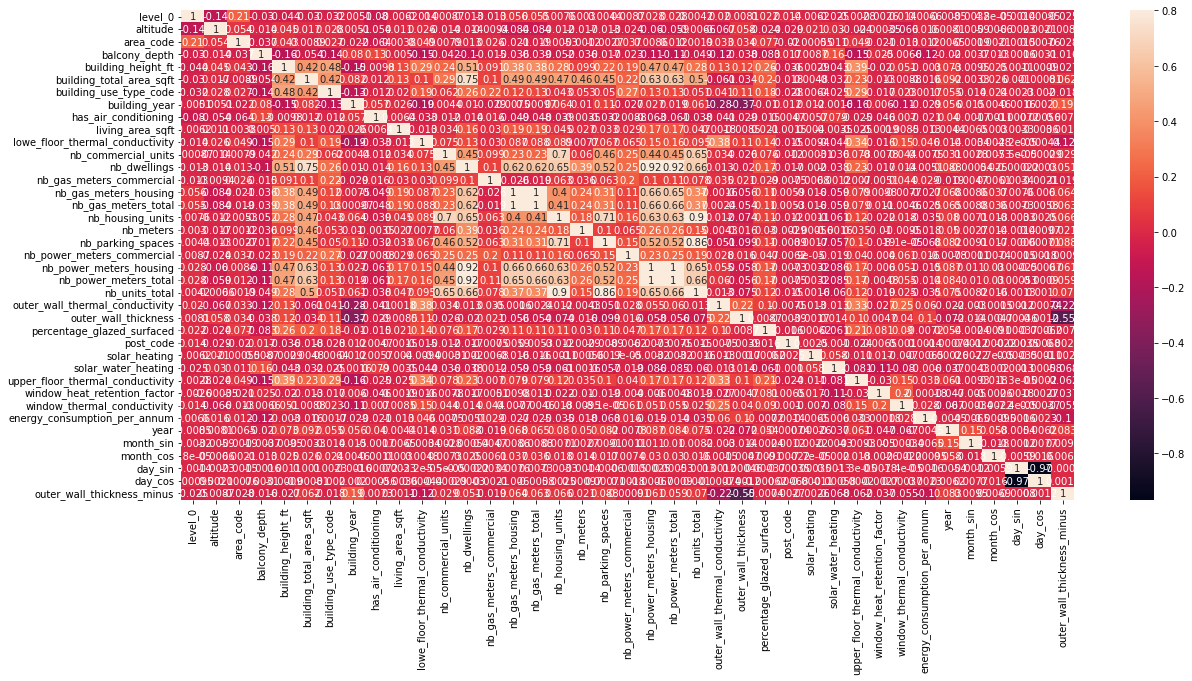

In [122]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20,9))
sns.heatmap(corrmat, vmax=0.8, annot=True)

<AxesSubplot:>

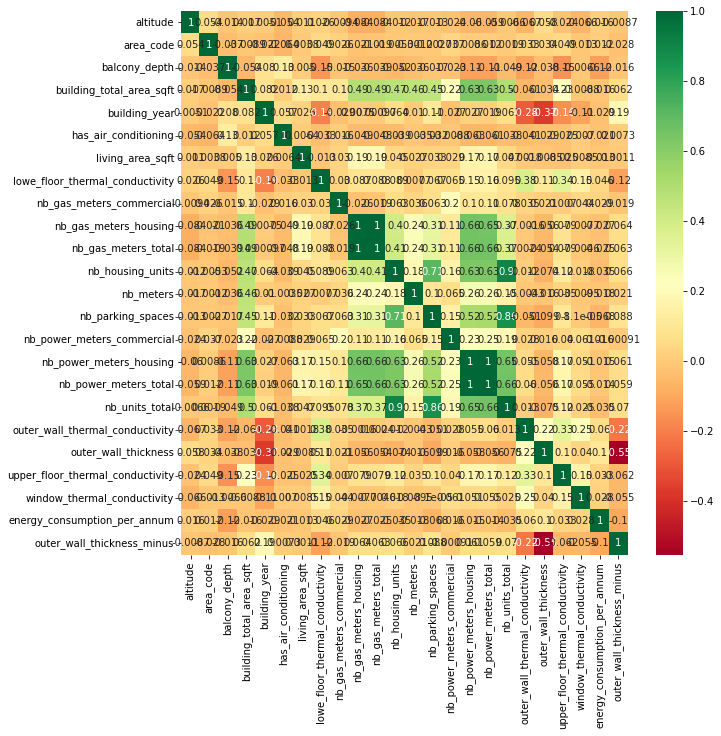

In [123]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat['energy_consumption_per_annum'])>0.01]
plt.figure(figsize=(10,10))
sns.heatmap(train[top_corr_features].corr(), annot=True, cmap = 'RdYlGn')

In [136]:
train.select_dtypes(exclude=['int64', 'float64']).columns

Index(['additional_heat_generators', 'additional_water_heaters',
       'bearing_wall_material', 'building_category', 'building_class',
       'building_period', 'building_type', 'building_use_type_description',
       'clay_risk_level', 'consumption_measurement_date',
       'has_air_conditioning', 'has_balcony', 'heat_generators',
       'heating_energy_source', 'heating_type', 'is_crossing_building',
       'lower_floor_adjacency_type', 'lower_floor_insulation_type',
       'lower_floor_material', 'main_heat_generators', 'main_heating_type',
       'main_water_heaters', 'main_water_heating_type', 'outer_wall_materials',
       'radon_risk_level', 'renewable_energy_sources', 'roof_material',
       'solar_heating', 'solar_water_heating', 'thermal_inertia',
       'upper_floor_adjacency_type', 'upper_floor_insulation_type',
       'upper_floor_material', 'ventilation_type', 'wall_insulation_type',
       'water_heaters', 'water_heating_energy_source', 'water_heating_type',
       'win

In [ ]:
corrmat = train_hot.corr()
#top_corr_features = corrmat.index[abs(corrmat['energy_consumption_per_annum'])>0.5]
#plt.figure(figsize=(10,10))
#sns.heatmap(train[top_corr_features].corr(), annot=True, cmap = 'RdYlGn')

# Models

## First tests

In [9]:
#x = np.array(train_hot.drop(['energy_consumption_per_annum'], 1)[:100000])
#y = np.array(train_hot['energy_consumption_per_annum'][:100000])

In [25]:
#xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)
#regressor = HistGradientBoostingRegressor()
#est = regressor.fit(xtrain, ytrain)
#est.score(xtrain, ytrain)

#predictions = regressor.predict(xtest)

# Calculation of Explained Variance
#from sklearn.model_selection import cross_val_score
#print(cross_val_score(regressor, x, y, cv=10, scoring="explained_variance").mean())

In [11]:
#train_hot.rename(columns={'building_period_<1948': "building_period_1948"}, inplace=True)
#test_hot.rename(columns={'building_period_<1948': "building_period_1948"}, inplace=True)

#dtrain = xgb.DMatrix(train_hot.drop(['energy_consumption_per_annum'], 1),
#                     label=train_hot['energy_consumption_per_annum'])

## Final model

In [9]:
# Suppression des outliers

q1=train_hot['energy_consumption_per_annum'].quantile(0.25)
q3=train_hot['energy_consumption_per_annum'].quantile(0.75)
IQR=q3-q1
train_hot = train_hot[((train_hot['energy_consumption_per_annum']>=(q1-1.5*IQR)) & (
    train_hot['energy_consumption_per_annum']<=(q3+1.5*IQR)))]

In [ ]:
train_hot.columns[train_hot.columns.str.contains('<|\[|\]')]

In [11]:
train_hot.rename(columns={'building_period_<1948': "building_period_1948"}, inplace=True)
test_hot.rename(columns={'building_period_<1948': "building_period_1948"}, inplace=True)

In [19]:
from xgboost import XGBRegressor
import sklearn

model = XGBRegressor(eta = 1) # 0.5

model.fit(train_hot.drop(['energy_consumption_per_annum'], 1),
         np.array(train_hot['energy_consumption_per_annum']),
         eval_metric = sklearn.metrics.explained_variance_score)

# 2-3 min

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [19]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [26]:
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedKFold

#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(model, x, y, scoring='explained_variance', cv=cv, n_jobs=-1)

# 14h57

In [21]:
scores

array([0.76529152, 0.76678054, 0.76294243, 0.76484096, 0.76600722])

In [21]:
predictions = model.predict(test_hot)

pd.DataFrame({'level_0':test_hot['level_0'],
             'energy_consumption_per_annum': predictions}).to_csv('submission5.csv',
                                                                 index=False)

In [40]:
pd.read_csv('hfactory_magic_folders/hi__paris_hackathon/building_energy_efficiency/datasets/sample_submission_sent.csv')

,level_0,energy_consumption_per_annum
0,1371914,240.0
1,618756,240.0
2,871032,240.0
3,1430640,240.0
4,86306,240.0
...,...,...
494935,845834,240.0
494936,279675,240.0
494937,811813,240.0
494938,369033,240.0


In [22]:
pd.read_csv('submission5.csv')

,level_0,energy_consumption_per_annum
0,1371914,215.649380
1,618756,319.223600
2,871032,209.480800
3,1430640,312.836430
4,86306,250.145980
...,...,...
494935,845834,430.539860
494936,279675,99.010155
494937,811813,290.855500
494938,369033,215.754000


In [27]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_